EE-311
======

Lab 5: Dimensionality Reduction
----------------------------------------

created by Zahra Farsijani and François Marelli on 25.03.2020

# Import libraries


In [1]:
import sklearn
from sklearn.datasets import load_iris, load_wine, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.decomposition
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore', category=sklearn.exceptions.ConvergenceWarning)

# Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for
each training instance. Not only does this make training extremely slow, it can also
make it much harder to find a good solution, and to visualize the data. This problem is often
referred to as the curse of dimensionality. 

In this lab we will explore different types of methods to reduce the dimenionality of our data:

1. Filter Methods
2. Wrapper Methods
3. Feature extraction

There are two main approaches for feature selection:

- wrapper methods, in which the features are selected using knowledge of the model
- filter methods, in which the selection of features is independent of model used

## 1.1 Filter Methods

A simple approach for feature selection is the filter method, in which we the features of the dataset are ranked according to a scoring criterion.

Selecting only the highest scoring features reduces the dimensionality of the dataset.

We will test this method on the iris dataset with all features, for binary classification.

In [2]:
data_X, data_y = load_iris(return_X_y=True)

mask = (data_y == 0) | (data_y == 1)

data_X = data_X[mask]
data_y = data_y[mask]

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.15, random_state=0)

Since we have four features, we cannot effectively plot the data. 

Instead, we try to get more insights into the correlation between various features by plotting 2D graphs for each possible selection of 2 features in the dataset.

What do you learn about the data? Can you see which features matter for classification and which ones don't?

*Some 2D plots look more separated than others. Those features are likely the best we can use for binary classification. It looks like the two last features are the best.*

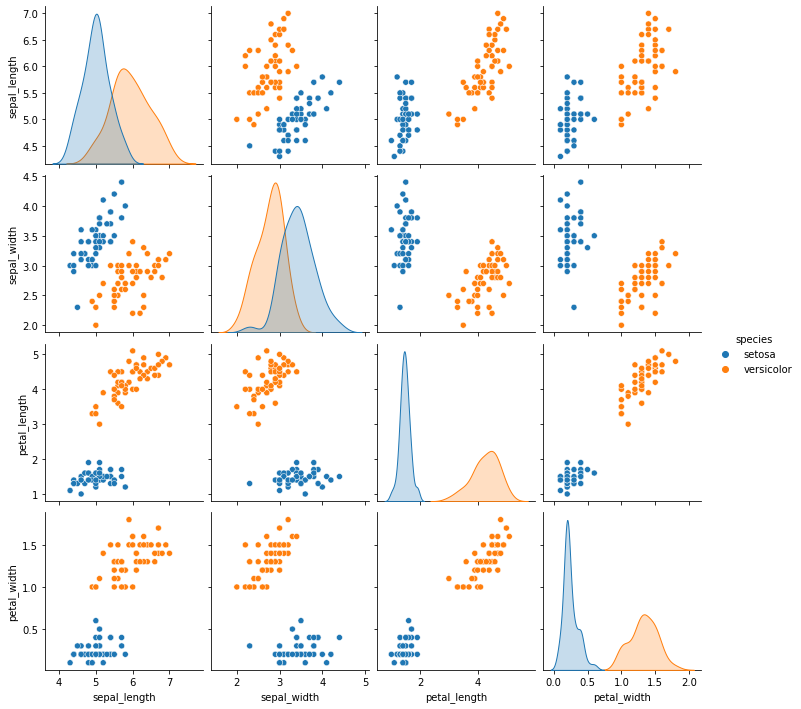

In [3]:
df = sns.load_dataset("iris")
df = df[df.species != 'virginica']
sns.pairplot(df, hue="species")
plt.show()

### Pearson's correlation coefficient filter

A simple criterion to measure the information contained in the features is to compute the correlation between the features and the labels.

Compute this criterion for all the features in the dataset, then select the two most informative features and show the resulting dataset in a scatterplot.

According to the previous plot, which combination of features do you expect to be selected?

*As expected, the two last features are selected.*

Correlation for each feature: [ 0.72829015 -0.69068434  0.96999023  0.96030697]
Features, from most to least important: [2 3 0 1]


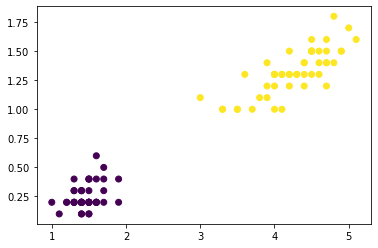

In [4]:

# Your turn to code!

correlation = (data_X - data_X.mean(0)).T.dot(data_y - data_y.mean()) / (data_X.std(0) * data_y.std() * data_X.shape[0])
criterion = np.abs(correlation)
print('Correlation for each feature: {}'.format(correlation))

f_sorted = criterion.argsort()[::-1]

print('Features, from most to least important: {}'.format(f_sorted))

plt.scatter(data_X[:, f_sorted[0]], data_X[:, f_sorted[1]], c=data_y)
plt.show()

## 1.2 Wrapper Methods

Wrapper methods select the best features by iteratively training the model and adding or removing features on the go.

We will investigate the two basic versions of wrapper methods: Forward search and Backward search.

### Forward search

In this method, we start with having no feature in the model. In each iteration, we add the feature which best improves our model performance till the addition of a new feature does not bring any improvement anymore.

Write a code that implements forward feature selection on a given model and dataset.

*Comments in the code!*

In [3]:
def forward_search(X_train, y_train, X_test, y_test, model):
    """
    Implement forward search feature selection.

    Parameters
    ----------    
    X_train, X_test : numpy array of shape [n_samples, n_features], datasets
        
    y_train, y_test : numpy array of shape [n_train_samples, ], labels (binary)
      
    model : a sklearn model implementing the .fit() and .score() functions (e.g. LogisticRegression())
    
    Returns
    -------
    numpy array of shape [n_features_selected,]
            Vector with the indexes of selected features, sorted by first selected
    """
    
    #######################################################
    # Your code here!
    
    # The list of features we keep, start with nothing
    features = []
    
    # Maximum iterations: we add each feature to the dataset => n_features
    for _ in range(X_train.shape[1]):
        # Set the initial score to an impossibly low value
        score = -1
        
        # We do not know what feature is the best to add yet
        best = None
        
        # If this is not the first iteration, compute the actual score of the current dataset
        if len(features) > 0:
            # Train and test only on the chosen features
            model.fit(X_train[:, features], y_train)
            score = model.score(X_test[:, features], y_test)
        
        # Ok we are ready to start iterating through all possible features
        for f in range(X_train.shape[1]):
            
            # If we are already using the feature, we cannot add it a second time: continue to the next one
            if f in features:
                continue
            
            # Create a copy of the feature list to temporarily append the new one
            f_train = features.copy()    
            f_train.append(f)
            
            # Train and score the model with the added feature
            model.fit(X_train[:, f_train], y_train)
            f_score = model.score(X_test[:, f_train], y_test)
            
            # If it does better than our base (or the previous best), this becomes the new best
            if f_score > score:
                score = f_score
                best = f
        
        # After going through all features, if we have a best one to add (i.e. if we improved the model by adding a feature), add it to the set and reiterate
        if best is not None:
            features.append(best)
            
        # If no new feature improves the model, we are done
        else:
            break
            
    return np.array(features)
    

Run your forward search algorithm on the iris dataset and print which features have been selected for a basic logistic regression model.

What dimensions are selected?

Did you expect it?

*Only the third feature is kept. Since the data are linearly separable along that dimension, the model will get 100% accuracy and will not be improved by the addition of another feature.*

In [6]:

# Code here!

model = LogisticRegression()

features = forward_search(X_train, y_train, X_test, y_test, model)

print('Selected features: {}'.format(features))


Selected features: [2]


#### The wine dataset

The iris dataset is too simple to demonstrate the use of wrapper methods.

We will use a bigger dataset called [the wine dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine).

How many features does this one have?

In [7]:
# Load and prepare data
data_X_wine, data_y_wine = load_wine(return_X_y=True)

mask = (data_y_wine == 0) | (data_y_wine == 1)

data_X_wine = data_X_wine[mask]
data_y_wine = data_y_wine[mask]

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(data_X_wine, data_y_wine, test_size=0.35, random_state=3)

print('Number of features:', data_X_wine.shape[1])

Number of features: 13


Use your forward search function to reduce the wine dataset using a logistic regression model, and show what features have been selected.

Further reduce the dimensionality by keeping only the 2 most relevant features.

Then, compare the model accuracy for both selected features and ALL features for the wine dataset.

*The model does not seem to suffer in performance when using the reduced dataset. This is not always true and depends on the data properties.*

Selected features: [12  6]
Accuracy with full dataset: 95.65%
Accuracy with reduced dataset: 95.65%


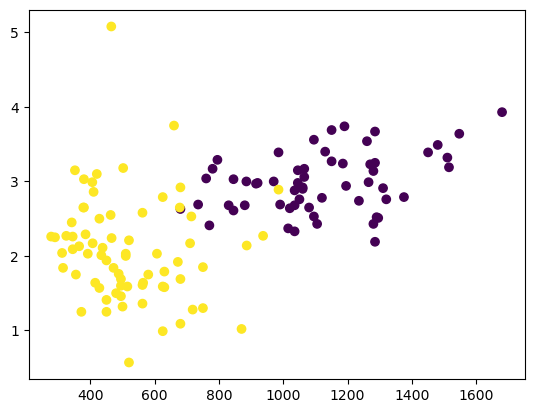

In [8]:
model = LogisticRegression()

features = forward_search(X_train_wine, y_train_wine, X_test_wine, y_test_wine, model)


# Here you code!

features = features[:2]

acc_full = model.fit(X_train_wine, y_train_wine).score(X_test_wine, y_test_wine)
acc_red = model.fit(X_train_wine[:, features], y_train_wine).score(X_test_wine[:, features], y_test_wine)

print('Selected features: {}'.format(features))

print('Accuracy with full dataset: {:.2f}%'.format(acc_full*100))
print('Accuracy with reduced dataset: {:.2f}%'.format(acc_red*100))

plt.scatter(data_X_wine[:, features[0]], data_X_wine[:, features[1]], c=data_y_wine)
plt.show()

### Backward Search (bonus)

In this method, as opposed to previous one, we start with using all features to train the model. 

In each iteration, we remove the feature which has the least effect on our model, untill removing of a new variable does not improve the performance of the model.

Write a code that implements forward feature selection on a given model and dataset. It can be very similar to your forward search!

In [9]:
def backward_search(X_train, y_train, X_test, y_test, model):
    """
    Implement backward search feature selection.

    Parameters
    ----------    
    X_train, X_test : numpy array of shape [n_samples, n_features], datasets
        
    y_train, y_test : numpy array of shape [n_train_samples, ], labels (binary)
      
    model : a sklearn model implementing the .fit() and .score() functions (e.g. LogisticRegression())
    
    Returns
    -------
    numpy array of shape [n_features_selected,]
            Vector with the indexes of selected features, sorted by importance of feature
    """
    
    
    #######################################################
    # Code here
    
    # Features we keep, start with all
    features = list(range(X_train.shape[1]))
    
    # Maximum iterations: we remove each feature to the dataset => n_features
    for _ in range(X_train.shape[1] - 1):
        # Train and test only on the chosen features to set the initial score
        model.fit(X_train[:, features], y_train)
        score = model.score(X_test[:, features], y_test)
        
        # We do not know what feature is the best to add yet
        best = None
                
        # Ok we are ready to start iterating through all remaining features
        for f in features:            
            
            # Create a copy of the feature list to temporarily remove the new one
            f_train = features.copy()    
            f_train.remove(f)
            
            # Train and score the model with less features
            model.fit(X_train[:, f_train], y_train)
            f_score = model.score(X_test[:, f_train], y_test)
            
            # If it does better than our base (or the previous best), this becomes the new best feature to be removed
            # If the score is the same, it is still an improvement because we have fewer features (=> non strict comparison)
            if f_score >= score:
                score = f_score
                best = f
        
        # After going through all features, if we have a best one to remove (i.e. if we improved the model by removing a feature), remove it from the set and reiterate
        if best is not None:
            features.remove(best)
            
        # If no new feature improves the model, we are done
        else:
            break
        
    return np.array(features)
    

Use your backward search function to reduce the wine dataset for a linear regression model.

Can you reduce it further down to 2 features only? (*Spoiler: yes you can, but how?*)

How does the ordering of features compare to the one obtained with the forward search?

*Interestingly enough, this method does not converge to the same subset as the forward search, but we get the same accuracy. We could reduce the space further down by running more iterations even after the performance of the model starts degrading. However, we would get worse accuracy then.*

In [10]:

# Here we code again!

model = LogisticRegression()

features = backward_search(X_train_wine, y_train_wine, X_test_wine, y_test_wine, model)

acc_full = model.fit(X_train_wine, y_train_wine).score(X_test_wine, y_test_wine)
acc_red = model.fit(X_train_wine[:, features], y_train_wine).score(X_test_wine[:, features], y_test_wine)

print('Selected features: {}'.format(features))

print('Accuracy with full dataset: {:.2f}%'.format(acc_full*100))
print('Accuracy with reduced dataset: {:.2f}%'.format(acc_red*100))



Selected features: [ 1  2  3  4  9 11]
Accuracy with full dataset: 95.65%
Accuracy with reduced dataset: 97.83%


## 2. Feature extraction using PCA

Where feature selection only tries to find the most important in the dataset, feature extraction actually combines multiple features to create new (better?) features.

We will focus on a well-known feature extraction method: the Principal Component Analysis (PCA).

PCA tries to define a new coordinate system such that the variance of the data is maximized along its main axes.

This then allows to select only the first few axes to reduce the dimension of the space while still keeping most of the representative information contained in the data.

**In this lab (and in the homework), we choose to not normalize 2D data for illustration purposes. We will later demonstrate the benefits of normalization on higher dimensionality datasets.**

For demonstration purposes, we will create a toy dataset that illustrates the concepts of PCA.

Wait... There are no labels!? Is this important?

*The computation of PCA does not take labels into account. PCA tries to minimize the information lost when reducing dimensionality from a representation point of view: it keeps most of the information about the distribution of the data as a whole. However, the representation information may not always be what is needed to get good classification performance: the separability of different classes may be along a different axis than the main data variance.*

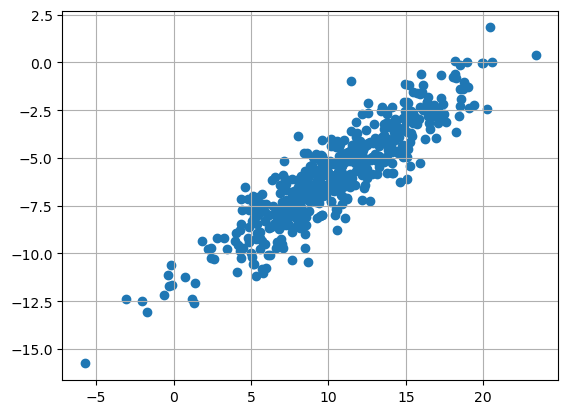

In [11]:
data_X_toy = np.random.default_rng(0).multivariate_normal([1, 0.5], [[1, 0], [0, 25]], 500)

# Rotate the gaussian
theta = np.radians(60)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
data_X_toy = data_X_toy.dot(R)
data_X_toy += (10, -5)

plt.scatter(data_X_toy[:,0], data_X_toy[:,1])
plt.grid()
plt.show()

PCA is computed by extracting the eigenvectors of the covariance matrix of the data. 

Write the code to compute the PCA and plot the principal directions on the graph using `draw_vector`. 

How do you interpret it? Can you tell which is the principal axis and how?

You can use:

`np.cov` to compute covariance

`np.linalg.eig` to perform eigen decomposition of a matrix

*The principal components define a new system of coordinates in which the variance is maximized along the coordinate axes. The principal axis is the one with the obvious maximal variance (the one in orange).*

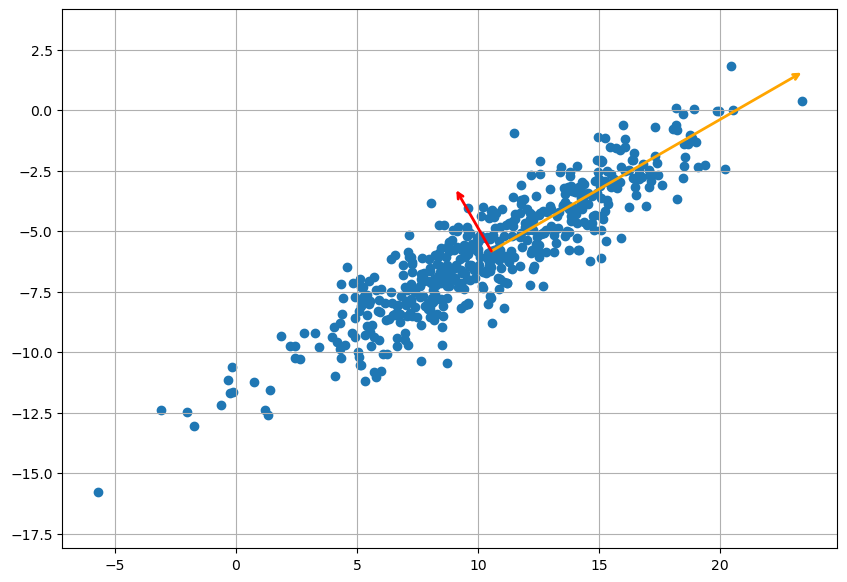

In [12]:
def draw_vector(v0, v1, color='b', ax=None):
    """
    Draw a vector on a matplotlib graph.

    Parameters:
        v0: np.array of size (2), the starting point of the vector
        v1: np.array of size (2), the end point of the vector
        color: str, color code for the plotting
        ax: which axes to plot to, leave empty to use current figure
    """
    
    ax = ax or plt.gca()
    arrowprops=dict(ec=color,
                    arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops, color='r')


# Code here, you must.

covar = np.cov(data_X_toy.T)
eigenval, eigenvec = np.linalg.eig(covar)

plt.figure(figsize=(10, 7))
plt.scatter(data_X_toy[:,0], data_X_toy[:,1])
plt.grid()

for i, vec in enumerate(eigenvec.T):
    col = ['orange', 'red']
    draw_vector(data_X_toy.mean(0), data_X_toy.mean(0) + vec * 3 * np.sqrt(eigenval[i]), col[i])

plt.axis('equal')
plt.show()



A numerically more stable way to compute PCA is Singular Value Decomposition (SVD).

Compute the principal components of the data using `np.linalg.svd` and check that the result is identical.

Do not forget to center the data first (zero mean)! Why is it important? Try without that and see the result.

*The singular value decomposition of a matrix $X$ gives the eigenvectors of $X^TX$. However, $X^TX$ is equivalent to the covariance matrix of $X$ only if the columns of $X$ have zero mean.
Thus SVD is suitable for PCA only if we center the data first.*

*Variance normalization is recommended but not necessary: PCA still works without normalization, but its result is different as the features with larger variances have much more weight in the computation.*

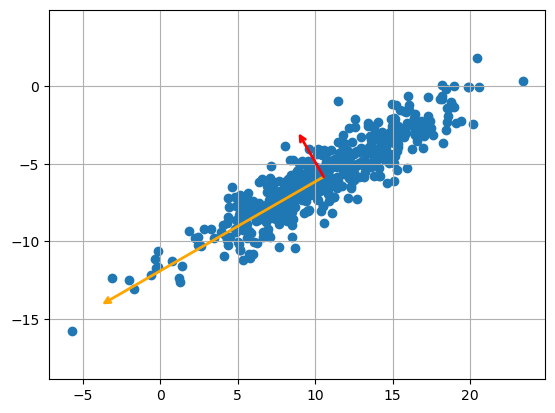

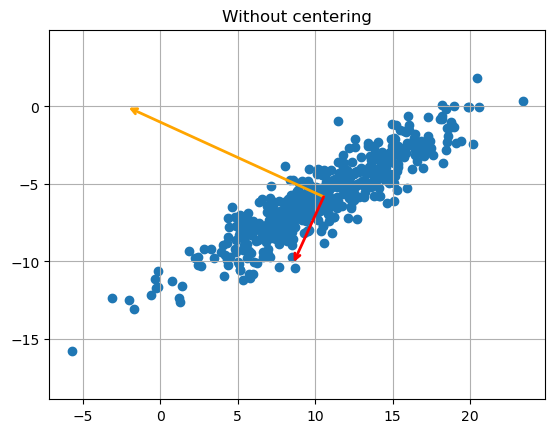

In [13]:

# Program here
data_X_centered = data_X_toy - data_X_toy.mean(0)
U, s, Vt = np.linalg.svd(data_X_centered)

plt.scatter(data_X_toy[:,0], data_X_toy[:,1])
plt.grid()

for i, vec in enumerate(Vt):
    col = ['orange', 'red']
    draw_vector(data_X_toy.mean(0), data_X_toy.mean(0) + vec * 0.15 * s[i], col[i])

plt.axis('equal')
plt.show()

# Without centering
U, s, Vt = np.linalg.svd(data_X_toy)

plt.scatter(data_X_toy[:,0], data_X_toy[:,1])
plt.grid()

for i, vec in enumerate(Vt):
    col = ['orange', 'red']
    draw_vector(data_X_toy.mean(0), data_X_toy.mean(0) + vec * 0.05 * s[i], col[i])

plt.title('Without centering')
plt.axis('equal')
plt.show()


### Dimensionality reduction

We can use PCA to reduce the dimension of a dataset by projecting it onto its N first principal components.

Let us show it on the iris dataset. Use SVD to compute its principal components, and plot the percentage of information contained in each principal component (ratio of variance explained by each component).

How many features seem relevant?

You can use `plt.bar( . )` for the figure.

*Since we want to compare the relative importance of components, it is crucial to normalize the dataset first, otherwise features with a large variance (features with a large scale) will look like they contain all the info.
Think about this: if plotting size [cm] vs age [years], the size is likely goint to range between 100 and 200, while the age will range between 0 and 100 (roughly). Without normalization, it would mean that the size is twice as important as the age in all computations, just because of the units used. Without prior information, we should always consider that all features are equivalent in terms of importance, and therefore normalize everything to get rid of units and range differences. Check the difference on the plots: without normalization it looks like the first component contains all the information (but it does not!).*

*The two first components contain more than 90% of the information. They are probably sufficient to efficiently represent our data.*

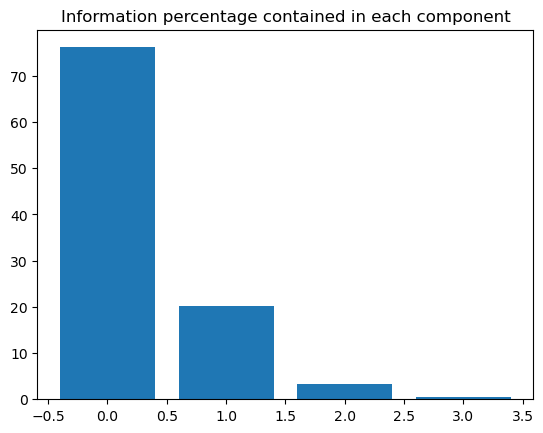

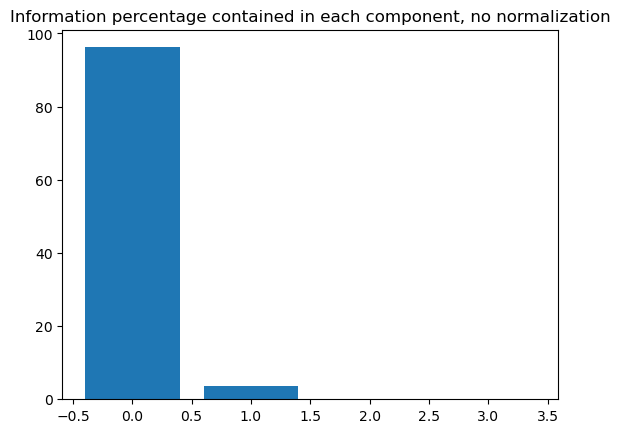

In [14]:

# Your code here

# Normalization !
X_centered = (data_X - data_X.mean(0)) / data_X.std(0)

_, s, Vt = np.linalg.svd(X_centered)

eigenvalues = np.power(s, 2)
info_ratio = eigenvalues / eigenvalues.sum()

plt.title('Information percentage contained in each component')
plt.bar(range(4), info_ratio*100)
plt.show()

# For the info, without normalization

_, s2, Vt2 = np.linalg.svd(data_X)

eigenvalues2 = np.power(s2, 2)
info_ratio2 = eigenvalues2 / eigenvalues2.sum()

plt.title('Information percentage contained in each component, no normalization')
plt.bar(range(4), info_ratio2*100)
plt.show()


We can choose to keep only the two first principal components to reduce the dimensionality of the dataset.

Reminder: to project the data into the reduced space, compute the matrix multiplication of the dataset matrix $X$ by the matrix $W_{d}$, defined as the matrix containing the first $d$ principal vectors (i.e., the matrix composed of the first $d$ right eigenvectors).

Reduce the iris dataset to a dimension of 2 using PCA and show the result as a scatterplot.

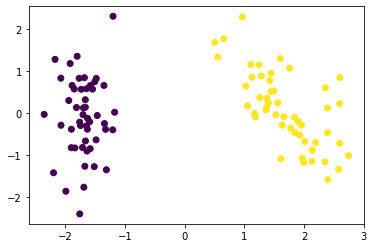

In [15]:

# Time to shine

W = Vt.T[:, :2]
X_reduced = X_centered.dot(W)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_y)
plt.show()

Fortunately enough, you do not have to write all this every time, as `sklearn.decomposition.PCA` is there for you!

Use it to reduce the iris dataset to a dimension of 2, and show a scatter of the result.

*The plot looks different from the last one, but it is totally equivalent to the one computed manually: if you check carefully, you will see that the vertical axis is just inversed. The sign of the principal components does not matter, only their direction.*

Information contained in principal components: [0.76158591 0.20169267]


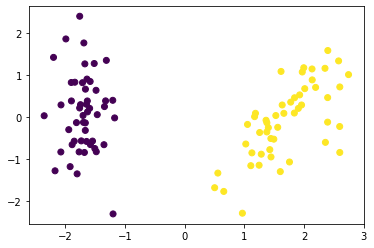

In [16]:

# One more time

pca = sklearn.decomposition.PCA(n_components=2).fit(X_centered)

reduced = pca.transform(X_centered)

print('Information contained in principal components: {}'.format(pca.explained_variance_ratio_))

plt.scatter(reduced[:, 0], reduced[:, 1], c=data_y)
plt.show()
